# 4ª filtro (variable interop distance)

## Generamos los datos

In [4]:
from sklearn.preprocessing import LabelEncoder
import torch
from generate_data import Data
import numpy as np

#device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------CAMBIO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Define el dispositivo que PyTorch usará para ejecutar los cálculos.
print(device)

#%%time
data = Data(layer_size=16, interop_distances=[0,1,2])

#%%time
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[1], [0.25, 0.75]]) # se omitirán muestras con una distancia de 1 entre operaciones relevantes, a partir de los datos obtenidos el 25% de los datos restantes irá a validación y el 75% a prueba.

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)


experiment_name = "interop_1"

#y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
#y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
#y_test = torch.from_numpy(y_test.astype(float)).float().to(device)
#---------------------------------------------------------------------------------------CAMBIO
# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

cpu


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


Number of samples: 1988 train | 941 val | 3765 test


## Cargamos los modelos

In [7]:
from models import *

best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))

C:\Users\franm\AppData\Local\Temp\ipykernel_2960\2913964062.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('./bestmodels/best

<All keys matched successfully>

# LSTM

## Funcion predict

In [8]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_SHAP_LSTM(x_train):
    best_lstm_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_lstm_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_lstm_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Generamos la explicacion

In [9]:
feature_names_mapped = [
    data.feature_names_one_hotted[i] if i < len(data.feature_names_one_hotted) else f"feature_{i}"
    for i in range(384)
]

# Print the mapped feature names for debugging
for i, feature in enumerate(feature_names_mapped):
    print(f"{i} - {feature}")

    

0 - f1-0-,
1 - f1-0-.
2 - f1-0-_
3 - f1-0-c
4 - f1-0-d
5 - f1-0-r
6 - f1-0-u
7 - f1-0-w
8 - f1-1-,
9 - f1-1-.
10 - f1-1-_
11 - f1-1-c
12 - f1-1-d
13 - f1-1-r
14 - f1-1-u
15 - f1-1-w
16 - f1-2-,
17 - f1-2-.
18 - f1-2-_
19 - f1-2-c
20 - f1-2-d
21 - f1-2-r
22 - f1-2-u
23 - f1-2-w
24 - f1-3-,
25 - f1-3-.
26 - f1-3-_
27 - f1-3-c
28 - f1-3-d
29 - f1-3-r
30 - f1-3-u
31 - f1-3-w
32 - f1-4-,
33 - f1-4-.
34 - f1-4-_
35 - f1-4-c
36 - f1-4-d
37 - f1-4-r
38 - f1-4-u
39 - f1-4-w
40 - f1-5-,
41 - f1-5-.
42 - f1-5-_
43 - f1-5-c
44 - f1-5-d
45 - f1-5-r
46 - f1-5-u
47 - f1-5-w
48 - f1-6-,
49 - f1-6-.
50 - f1-6-_
51 - f1-6-c
52 - f1-6-d
53 - f1-6-r
54 - f1-6-u
55 - f1-6-w
56 - f1-7-,
57 - f1-7-.
58 - f1-7-_
59 - f1-7-c
60 - f1-7-d
61 - f1-7-r
62 - f1-7-u
63 - f1-7-w
64 - f1-8-,
65 - f1-8-.
66 - f1-8-_
67 - f1-8-c
68 - f1-8-d
69 - f1-8-r
70 - f1-8-u
71 - f1-8-w
72 - f1-9-,
73 - f1-9-.
74 - f1-9-_
75 - f1-9-c
76 - f1-9-d
77 - f1-9-r
78 - f1-9-u
79 - f1-9-w
80 - f1-10-,
81 - f1-10-.
82 - f1-10-_
83 - f1-10-

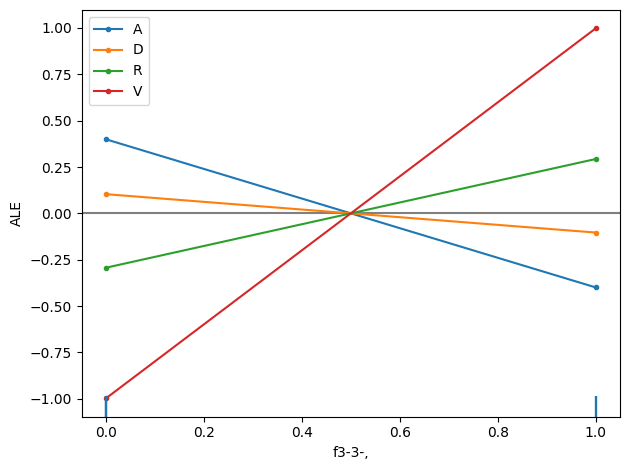

In [19]:
#%pip install alibi

from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt

nombres_clases = ["A", "D", "R", "V"]


# Definir el explainer ALE
ale_explainer_lstm = ALE(predictor=predict_fn_SHAP_LSTM, feature_names=feature_names_mapped)

# Características clave para LSTM
features_lstm = [280]  # Indices correspondientes a las caracteristicas que queramos analizar

# Generar la explicación para características seleccionadas
ale_lstm = ale_explainer_lstm.explain(x_test, features=features_lstm)

fig = plot_ale(ale_lstm)

# Cambiar las etiquetas de la leyenda
legend = fig[0, 0].get_legend()
if legend:
    for i, text in enumerate(legend.get_texts()):
        text.set_text(nombres_clases[i])

# Mostrar gráfico actualizado
plt.tight_layout()
plt.show()


# CNN

## Funcion predict

In [13]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_SHAP_CNN(x_train):
    best_cnn_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_conv_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_cnn_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Generamos la explicacion

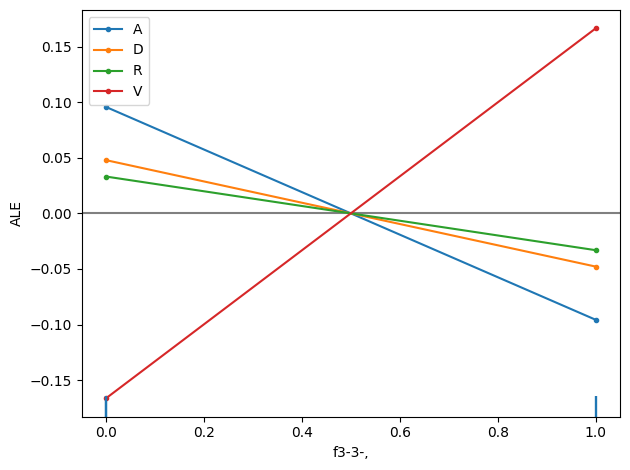

In [20]:
#%pip install alibi

from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt

nombres_clases = ["A", "D", "R", "V"]

# Definir el explainer ALE
ale_explainer_cnn = ALE(predictor=predict_fn_SHAP_CNN, feature_names=feature_names_mapped)

# Características clave para LSTM
features_cnn = [280]  # Indices correspondientes a las caracteristicas que queramos analizar

# Generar la explicación para características seleccionadas
ale_cnn = ale_explainer_cnn.explain(x_test, features=features_cnn)

# Graficar ALE
fig = plot_ale(ale_cnn)

# Cambiar las etiquetas de la leyenda
legend = fig[0, 0].get_legend()
if legend:
    for i, text in enumerate(legend.get_texts()):
        text.set_text(nombres_clases[i])

# Mostrar gráfico actualizado
plt.tight_layout()
plt.show()